In [68]:
import logging

from IPython.core.display_functions import clear_output
from qiskit import QuantumCircuit, transpile, assemble
from qiskit_aer import AerSimulator
import numpy as np
import matplotlib.pyplot as plt

# Setup logging
logging.basicConfig(filename='quantum_embedding.log', level=logging.INFO, 
                    format='%(asctime)s - %(levelname)s - %(message)s')

In [69]:
def quantum_encoder(theta, n, m):
    qc = QuantumCircuit(n + m)
    for i in range(n):
        qc.ry(theta[i], i)
        qc.cry(theta[n + i], i, [n + j for j in range(m)])
    return qc

def matrix_inverse_evolution(qc, beta, adj_matrix, n, t=1):
    identity = np.eye(2**n)
    I_minus_betaA = identity - beta * adj_matrix
    
    for _ in range(t):
        for i in range(2**n):
            for j in range(2**n):
                if I_minus_betaA[i][j] != 0:
                    angle = -2 * I_minus_betaA[i][j]
                    qc.rz(angle, j % n)
    return qc

def hadamard_test(theta, beta, adj_matrix, n, m, t=1):
    qc = QuantumCircuit(1 + n + m, 1)  # 1 ancilla qubit + address and embedding registers, 1 classical bit
    
    qc.h(0)  # Hadamard on ancilla qubit
    
    encoder_qc = quantum_encoder(theta, n, m)
    qc = qc.compose(encoder_qc, qubits=range(1, n + m + 1))
    
    # apply matrix-inverse evolution
    controlled_U = QuantumCircuit(n + m)
    controlled_U = matrix_inverse_evolution(controlled_U, beta, adj_matrix, n, t)
    qc = qc.compose(controlled_U.control(1), qubits=[0] + list(range(1, n + m + 1)))
    
    qc.h(0) # second Hadamard on ancilla qubit
    
    # Measure only the ancilla qubit
    qc.measure(0, 0)
    
    return qc

def estimate_L(theta, adj_matrix, beta, n, m, t):
    qc = hadamard_test(theta, beta, adj_matrix, n, m, t)
    logging.info(f"Quantum Circuit:\n{qc}")
    simulator = AerSimulator()
    transpiled_qc = transpile(qc, simulator)
    qobj = assemble(transpiled_qc)
    result = simulator.run(qobj).result()
    counts = result.get_counts()
    
    # Calculate expectation value <psi|U|psi>
    logging.info(f"Counts: {counts}")
    expectation_value = (counts.get('0', 0) - counts.get('1', 0)) / sum(counts.values())
    return expectation_value

In [70]:
def optimize_parameters(theta, adj_matrix, beta, alpha, delta_theta, n, m, t, max_iter=200):
    objective_values = []
    for iteration in range(max_iter):
        grad = np.zeros_like(theta)
        for i in range(len(theta)):
            theta_plus = theta.copy()
            theta_minus = theta.copy()
            theta_plus[i] += delta_theta
            theta_minus[i] -= delta_theta
            L_plus = estimate_L(theta_plus, adj_matrix, beta, n, m, t)
            L_minus = estimate_L(theta_minus, adj_matrix, beta, n, m, t)
            grad[i] = (L_plus - L_minus) / (2 * delta_theta)
        
        theta += alpha * grad
        L_theta = estimate_L(theta, adj_matrix, beta, n, m, t)
        objective_values.append(L_theta)
        
        logging.info(f"Iteration {iteration + 1}: Objective Value = {L_theta}")
        logging.info(f"Iteration {iteration + 1}: Gradients = {grad}")
        logging.info(f"Iteration {iteration + 1}: Parameters (theta) = {theta}")

        grad_norm = np.linalg.norm(grad)
        if grad_norm < 1e-6:
            logging.info(f"Convergence reached at iteration {iteration + 1}")
            print(f"Gradient Norm: {grad_norm:.6f} < {1e-6:.6f} !!!")
            break
        print(f"Gradient Norm: {grad_norm:.6f} > {1e-6:.6f}")
    return theta, objective_values

In [71]:
def check_convergence_criterion(adj_matrix, beta):
    eigenvalues = np.linalg.eigvals(beta * adj_matrix)
    if np.max(np.abs(eigenvalues)) >= 1:
        raise ValueError("Convergence criterion is not satisfied.")
    
def check_adjacency_matrix_dimension(adj_matrix):
    if adj_matrix.shape[0] != adj_matrix.shape[1]:
        raise ValueError("Adjacency matrix must be square.")
    if adj_matrix.shape[0] < 2:
        raise ValueError("Adjacency matrix must be at least 2x2.")
    
def extend_adjacency_matrix(adj_matrix):
    N = adj_matrix.shape[0]
    n = int(np.ceil(np.log2(N)))

    if 2**n == N:
        return adj_matrix

    print(f"Extending the matrix dimensionality to the nearest power of 2.")
    extended_adj_matrix = np.zeros((2**n, 2**n))
    extended_adj_matrix[:N, :N] = adj_matrix
    return extended_adj_matrix

C:\Users\matss\AppData\Local\Temp\ipykernel_24440\567431436.py:49: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.14 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  result = simulator.run(qobj).result()


Gradient Norm: 2.913366 > 0.000001
Gradient Norm: 2.368038 > 0.000001
Gradient Norm: 3.134142 > 0.000001
Gradient Norm: 4.091086 > 0.000001
Gradient Norm: 3.024192 > 0.000001
Gradient Norm: 3.203363 > 0.000001
Gradient Norm: 4.275738 > 0.000001
Gradient Norm: 5.845524 > 0.000001
Gradient Norm: 2.873816 > 0.000001
Gradient Norm: 5.346178 > 0.000001
Gradient Norm: 7.908348 > 0.000001
Gradient Norm: 3.933014 > 0.000001
Gradient Norm: 2.638527 > 0.000001
Gradient Norm: 3.213766 > 0.000001
Gradient Norm: 3.401186 > 0.000001
Gradient Norm: 6.612561 > 0.000001
Gradient Norm: 5.430250 > 0.000001
Gradient Norm: 4.297985 > 0.000001
Gradient Norm: 4.595035 > 0.000001
Gradient Norm: 5.249875 > 0.000001
Gradient Norm: 4.533396 > 0.000001
Gradient Norm: 2.207550 > 0.000001
Gradient Norm: 5.577531 > 0.000001
Gradient Norm: 3.860820 > 0.000001
Gradient Norm: 5.906387 > 0.000001
Gradient Norm: 6.263718 > 0.000001
Gradient Norm: 3.016298 > 0.000001
Gradient Norm: 6.830355 > 0.000001
Gradient Norm: 4.248

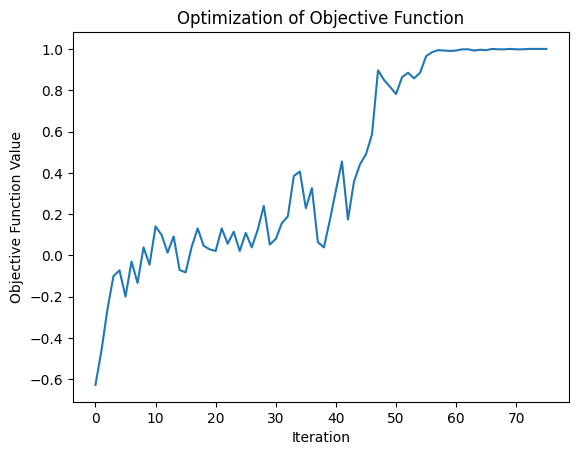

Optimized Parameters: [0.01640572 3.12897623 5.58770564 5.03518989]


In [72]:
# np.random.seed(42)
adj_matrix = np.array([
    [0, 1, 0, 0],
    [1, 0, 1, 0],
    [0, 1, 0, 1],
    [0, 0, 1, 0],  
])

N = adj_matrix.shape[0]
n = int(np.ceil(np.log2(N)))  # Number of qubits in the address register
m = 1  # Number of qubits in the embedding register (adjust as needed)

gamma = 0.5
alpha = 0.1 # learning rate
delta_theta = 0.01
beta = 0.1 # controls amount of higher-order info
t = 1  # Time parameter for evolution

theta = np.random.rand(2 * n) * 2 * np.pi  # Initialize theta randomly

# Check some stuff
check_adjacency_matrix_dimension(adj_matrix)
check_convergence_criterion(adj_matrix, beta)
ajd_matrix = extend_adjacency_matrix(adj_matrix)

optimized_theta, objective_values = optimize_parameters(theta, adj_matrix, beta, alpha, delta_theta, n, m, t)

# Plotting the objective function
plt.plot(objective_values)
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')
plt.title('Optimization of Objective Function')
plt.show()

print("Optimized Parameters:", optimized_theta)

In [74]:
from qiskit.circuit import ParameterVector

def get_embedding(N, n, m):
    theta = ParameterVector('θ', N)
    qc = QuantumCircuit(n + m)
    for i in range(n):
        qc.ry(theta[i], i)
        qc.cry(theta[n + i], i, [n + j for j in range(m)])
    return qc, theta

In [75]:
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


# Obtain the parameterized quantum circuit
embedding_qc, theta = get_embedding(N, n, m)

# Assign the optimized parameters to the quantum circuit
embedding_qc = embedding_qc.assign_parameters(dict(zip(theta, optimized_theta)))

display(embedding_qc.draw())

# Initialize the quantum kernel with the parameterized feature map
kernel = FidelityQuantumKernel(feature_map=embedding_qc)

# Evaluate the kernel matrix
kernel_matrix = kernel.evaluate(x_vec=ajd_matrix)

print("Kernel Matrix:")
print(kernel_matrix)

# Perform clustering with the kernel matrix
num_clusters = 2  # Define the number of clusters
kmeans = KMeans(n_clusters=num_clusters)

# Fit the model using the kernel matrix
kmeans.fit(kernel_matrix)

# Predict the clusters for the data points
cluster_labels = kmeans.labels_

print("Cluster Labels:", cluster_labels)

# Plot the kernel matrix
plt.imshow(kernel_matrix, interpolation='nearest')
plt.title("Kernel Matrix")
plt.colorbar()
plt.show()

┌──────────────┐                            
q_0: ┤ Ry(0.016406) ├──────■─────────────────────
     └┬───────────┬─┘      │                     
q_1: ─┤ Ry(3.129) ├────────┼─────────────■───────
      └───────────┘  ┌─────┴──────┐┌─────┴──────┐
q_2: ────────────────┤ Ry(5.5877) ├┤ Ry(5.0352) ├
                     └────────────┘└────────────┘

ValueError: x_vec and class feature map have incompatible dimensions.
x_vec has 4 dimensions, but feature map has 0.

In [ ]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import normalized_mutual_info_score

sc = SpectralClustering(n_clusters=2, affinity='precomputed')

cluster_labels = sc.fit_predict(kernel_matrix)

print("Cluster Labels:", cluster_labels)

Cluster Labels: [1 0 1 1 1 1 1 0]
